# A Gentle Introduction to Transfer Learning

According to [Andrew Ng](http://www.andrewng.org/), cofounder of Coursera and Adjunct Professor at Stanford, Transfer Learning will be the next driver of Machine Learning commercial success.

[Transfer Learning](http://cs231n.github.io/transfer-learning/) is a Machine Learning technique that allows to reutilize an already trained convolutional neural network (CNN) on a specific dataset and adapt it, or transfer it, to a different dataset. The most common transfer learning dataset is [ImageNet](http://image-net.org/), which contains 1.2 million images with 1000 categories.

The reason you want to reuse a trained CNN is because it typically takes a long time to train. For example, training ResNet18 for 30 epochs in 4 NVIDIA K80 GPU [took us 3 days](https://blogs.technet.microsoft.com/machinelearning/2016/11/15/imagenet-deep-neural-network-training-using-microsoft-r-server-and-azure-gpu-vms/). Training ResNet152 for 120 epochs in 4 NVIDIA K80 GPUs takes 4 months. 



In [1]:
import sys
import os
import numpy as np
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torchvision import models
from utils import (get_gpu_name, get_number_processors, plot_pytorch_data_stream, train_model, create_dataset, 
                   available_models, plot_metrics)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())
print("GPU: ", get_gpu_name())

%matplotlib inline
%load_ext autoreload
%autoreload 2

OS:  linux
Python:  3.5.4 | packaged by conda-forge | (default, Nov  4 2017, 10:11:29) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
PyTorch:  0.2.0_3
Numpy:  1.13.3
Number of CPU processors:  24
GPU:  ['Tesla M60', 'Tesla M60', 'Tesla M60', 'Tesla M60']


In [2]:
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

In [3]:
MODEL_NAME = 'resnet18'
BATCH_SIZE = 64
SETS = ['train', 'val']
NUM_GPUS = 4
EPOCHS = 15
LR = 0.0001
LR_STEP = 0.1
LR_EPOCHS = 10
MOMENTUM = 0.9

## Model and utilities

In [4]:
model_names = available_models()
print(model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [5]:
def finetune(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=True):
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_ft = models.__dict__[model_name](pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_ft = nn.DataParallel(model_ft)
    model_ft = model_ft.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # All parameters are being optimized
    optimizer = SGD(model_ft.parameters(), lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_ft = train_model(dataloaders, model_ft, sets, criterion, optimizer, exp_lr_scheduler, 
                           num_epochs=num_epochs, verbose=verbose)
    return model_ft

In [6]:
def freeze_and_train(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=True):
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](pretrained=True)
    for param in model_conv.parameters(): #params have requires_grad=True by default
        param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_conv = nn.DataParallel(model_conv)
    model_conv = model_conv.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # Only parameters of final layer are being optimized 
    if num_gpus > 1:
        params = model_conv.module.fc.parameters()
    else:
        params = model_conv.fc.parameters()
    optimizer = SGD(params, lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, sets, criterion, optimizer, exp_lr_scheduler, 
                             num_epochs=num_epochs, verbose=verbose)
    return model_conv

## Datasets
We are going to use the dataset [hymenoptera](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [7]:
DATA_ROOT = '/datadrive'

HYMENOPTERA_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_data')
HYMENOPTERA_GRAY_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_gray')

SIMPSONS_ROOT = os.path.join(DATA_ROOT, 'simpsons', 'simpsons')
SIMPSONS_GRAY_ROOT = os.path.join(DATA_ROOT, 'simpsons', 'simpsons_gray')

DOGS_CATS_ROOT = os.path.join(DATA_ROOT, 'dogs_vs_cats', 'dogs_vs_cats')
DOGS_CATS_GRAY_ROOT = os.path.join(DATA_ROOT, 'dogs_vs_cats', 'dogs_vs_cats_gray')

CALTECH256_ROOT = os.path.join(DATA_ROOT, 'caltech256','caltech256')
CALTECH256_GRAY_ROOT = os.path.join(DATA_ROOT, 'caltech256','caltech256')

In [8]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)

There are 2 clases in the dataset: {
    "ants": 0,
    "bees": 1
}
Sets sizes:  {
    "train": 244,
    "val": 153
}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


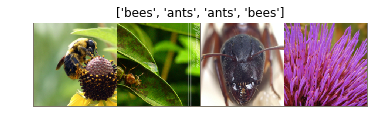

In [9]:
plot_pytorch_data_stream(data_hymenoptera['train'], max_images=4)

In [10]:
data_hymenoptera_gray = create_dataset(HYMENOPTERA_GRAY_ROOT, batch_size=BATCH_SIZE)

There are 2 clases in the dataset: {
    "ants": 0,
    "bees": 1
}
Sets sizes:  {
    "train": 244,
    "val": 153
}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


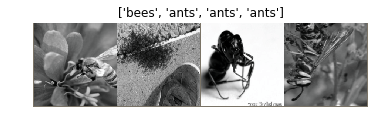

In [11]:
plot_pytorch_data_stream(data_hymenoptera_gray['train'], max_images=4)

In [12]:
data_simpsons = create_dataset(SIMPSONS_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 20 clases in the dataset: {
    "abraham_grampa_simpson": 0,
    "apu_nahasapeemapetilon": 1,
    "bart_simpson": 2,
    "charles_montgomery_burns": 3,
    "chief_wiggum": 4,
    "comic_book_guy": 5,
    "edna_krabappel": 6,
    "homer_simpson": 7,
    "kent_brockman": 8,
    "krusty_the_clown": 9,
    "lenny_leonard": 10,
    "lisa_simpson": 11,
    "marge_simpson": 12,
    "mayor_quimby": 13,
    "milhouse_van_houten": 14,
    "moe_szyslak": 15,
    "ned_flanders": 16,
    "nelson_muntz": 17,
    "principal_skinner": 18,
    "sideshow_bob": 19
}
Sets sizes:  {
    "train": 15638,
    "val": 3910
}
Number of items in set train: {0: 730, 1: 498, 2: 1074, 3: 954, 4: 789, 5: 375, 6: 366, 7: 1797, 8: 398, 9: 965, 10: 248, 11: 1083, 12: 1033, 13: 197, 14: 863, 15: 1162, 16: 1163, 17: 286, 18: 955, 19: 702}
Number of items in set val: {0: 183, 1: 125, 2: 268, 3: 239, 4: 197, 5: 94, 6: 91, 7: 449, 8: 100, 9: 241, 10: 62, 11: 271, 12: 258, 13: 49, 14: 216, 15: 290, 16: 291, 17: 72, 

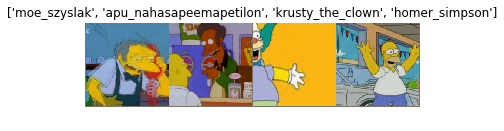

In [13]:
plot_pytorch_data_stream(data_simpsons['train'], max_images=4)

In [14]:
data_simpsons_gray = create_dataset(SIMPSONS_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 20 clases in the dataset: {
    "abraham_grampa_simpson": 0,
    "apu_nahasapeemapetilon": 1,
    "bart_simpson": 2,
    "charles_montgomery_burns": 3,
    "chief_wiggum": 4,
    "comic_book_guy": 5,
    "edna_krabappel": 6,
    "homer_simpson": 7,
    "kent_brockman": 8,
    "krusty_the_clown": 9,
    "lenny_leonard": 10,
    "lisa_simpson": 11,
    "marge_simpson": 12,
    "mayor_quimby": 13,
    "milhouse_van_houten": 14,
    "moe_szyslak": 15,
    "ned_flanders": 16,
    "nelson_muntz": 17,
    "principal_skinner": 18,
    "sideshow_bob": 19
}
Sets sizes:  {
    "train": 15638,
    "val": 3910
}
Number of items in set train: {0: 730, 1: 498, 2: 1074, 3: 954, 4: 789, 5: 375, 6: 366, 7: 1797, 8: 398, 9: 965, 10: 248, 11: 1083, 12: 1033, 13: 197, 14: 863, 15: 1162, 16: 1163, 17: 286, 18: 955, 19: 702}
Number of items in set val: {0: 183, 1: 125, 2: 268, 3: 239, 4: 197, 5: 94, 6: 91, 7: 449, 8: 100, 9: 241, 10: 62, 11: 271, 12: 258, 13: 49, 14: 216, 15: 290, 16: 291, 17: 72, 

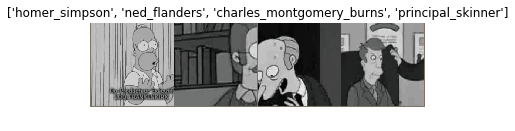

In [15]:
plot_pytorch_data_stream(data_simpsons_gray['train'], max_images=4)

In [16]:
data_dogs_vs_cats = create_dataset(DOGS_CATS_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 2 clases in the dataset: {
    "cats": 0,
    "dogs": 1
}
Sets sizes:  {
    "train": 20000,
    "val": 5000
}
Number of items in set train: {0: 10000, 1: 10000}
Number of items in set val: {0: 2500, 1: 2500}


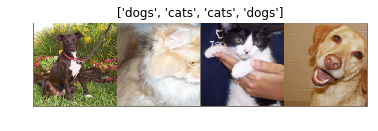

In [17]:
plot_pytorch_data_stream(data_dogs_vs_cats['train'], max_images=4)

In [18]:
data_dogs_vs_cats_gray = create_dataset(DOGS_CATS_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 2 clases in the dataset: {
    "cats": 0,
    "dogs": 1
}
Sets sizes:  {
    "train": 20000,
    "val": 5000
}
Number of items in set train: {0: 10000, 1: 10000}
Number of items in set val: {0: 2500, 1: 2500}


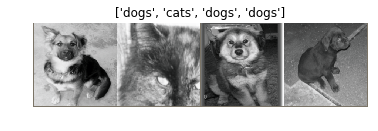

In [19]:
plot_pytorch_data_stream(data_dogs_vs_cats_gray['train'], max_images=4)

In [ ]:
data_caltech256 = create_dataset(CALTECH256_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

In [ ]:
plot_pytorch_data_stream(data_caltech256['train'], max_images=4)

In [ ]:
data_caltech256_gray = create_dataset(CALTECH256_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

In [ ]:
plot_pytorch_data_stream(data_caltech256_gray['train'], max_images=4)

## Training

In [ ]:
val_acc_ft = "Validation accuracy finetuning"
val_acc_fr = "Validation accuracy freezing"
df = pd.DataFrame(columns=[val_acc_ft, val_acc_fr])


In [ ]:
model, metrics = finetune(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
dataset_name = "Dataset Hymenoptera"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_hymenoptera_gray, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
dataset_name = "Dataset Hymenoptera gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_hymenoptera_gray, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

Transfer learning with Simpsons dataset

In [ ]:
model, metrics = finetune(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
dataset_name = "Dataset Simpsons"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_simpsons_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
dataset_name = "Dataset Simpsons gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_simpsons_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

Transfer learning with dogs vs cats

In [ ]:
model, metrics = finetune(data_dogs_vs_cats, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
dataset_name = "Dataset Dogs vs Cats"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_dogs_vs_cats, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_dogs_vs_cats_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
dataset_name = "Dataset Dogs vs Cats gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_dogs_vs_cats_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_caltech256, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
dataset_name = "Dataset Caltech256"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_caltech256, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_caltech256_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
dataset_name = "Dataset Caltech256 gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_caltech256_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

In [ ]:
df